# Spam detection in SMS data

***(ETL Notebook)***

## 1. Introduction

Spam is an unwanted message sent electronically whose content may be malicious. The spam messages are dangerous in many ways such as 

1. Exposure of private and personal information through undesired advertisement
2. Falling victim to a fraud or financial scheme
3. Being wrongly attracted into malware and phishing websites
4. Being involuntary exposed to inappropriate online content

Since SMS messages are usually inexpensive for spammers to send, they are very appealing for unrightful exploitation.

## 2. Purpose

The main purpose of this project is to build a spam detection model. Particularly, our focus lies on building a binary classification model to detect whether the text messages are spam or ham (not spam).

## 2. Data

### 2.1. Data Collection

This a text data downloaded from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). It contains 5572 SMS phone messages. The data were collected for the purpose of mobile phone spam research. The data have been labeled as either spam or ham. Below, the data downloaded from the website is transformed to a pandas dataframe for ease of data exploration. 

In [1]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

def __iter__(self): return 0


client_0fdd3f4f5bb549fab8a52672d7c21f58 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='********',
    ibm_auth_endpoint="********",
    config=Config(signature_version='********'),
    endpoint_url='********')

body = client_0fdd3f4f5bb549fab8a52672d7c21f58.get_object(Bucket='********',Key='SMSSpamCollection.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pdf = pd.read_csv(body,index_col=[0])
pdf.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 2.2 Exploratory Data Analysis (EDA)

In this section, we perform some data visualization and summary statistics to have better understanding about the data. 

First, we check whether there is any missing value in our data.

Second, the **describe** method from pandas provides a summary distribution such as, 

- There are 5572 lables and messages. 
- There are two unique lables indicating "*ham*" and "*spam*".
- There are less unique messages (5169) than total message (5572) indicating some repeated messages.
- The top label is ham and the top message in the data is "*Sorry, I'll call later*".

In [2]:
# Check for missing value
pdf.isnull().sum()

Label    0
Text     0
dtype: int64

Therefore, there is no missing value in our data. 

In [3]:
# Generate a summary distribution
pdf.describe()

,Label,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


From the above summary table, one can see that there are 403 duplicated messages, i.e., 5572-5169 = 403. Below, the duplicated_row shows some of these duplicated messages.

In [4]:
duplicated_row = pdf[pdf.duplicated()]
print(duplicated_row[:10])

    Label                                               Text
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...
444   ham                             Sorry, I'll call later
533   ham                  Gudnite....tc...practice going on
655   ham                       Did u got that persons story


In order to check whether the data is balanced or not, let's group by the labels *spam* and *ham*. From the table below, it can be easily observed that there are 4825 *ham* messages and 747 *spam* messages. This further indicates that the data is imbalanced and hence, we need to fix this later. 

Furthermore, one can realize that the most popular ham message is "*Sorry, I'll call later*", which appears 30 times in the data, while the most popular spam message is "*Please call our coustomer service representative ...*" with the occurence of 4 times in the data. 

In [5]:
pdf.groupby('Label').describe().T

Label                           ham  \
Text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

Label                                                     spam  
Text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

Before proceeding further, let's explore more about the data by label groups. Below, a WordCloud and distribution bar chart are presented to visualize the data.

In [6]:
!pip install wordcloud

     |████████████████████████████████| 363 kB 25.4 MB/s eta 0:00:01


In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Since the WorldCloud visualizes the most frequent words in the given text, we now extract words that most commonly appeared in ham and spam messages via removing the *stop words*, i.e., the words which do not add much meaning to a sentence, such as *the*, *he*, *she*, *have*, etc.

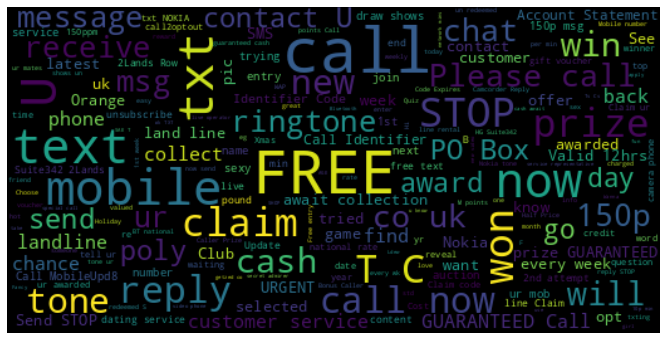

In [8]:
# extract the most common spam messages
spamText = ""
for text in pdf['Text'][pdf['Label'] == 'spam']:
    spamText += text

# wordcloud of spam messages
spamcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50).generate(spamText)
plt.figure(figsize=(12, 6))
plt.imshow(spamcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The spam message WordCloud above shows that words such as **free**, **call**, **text**, **claim**, **reply** are the most commonly appeared words in spam messages.

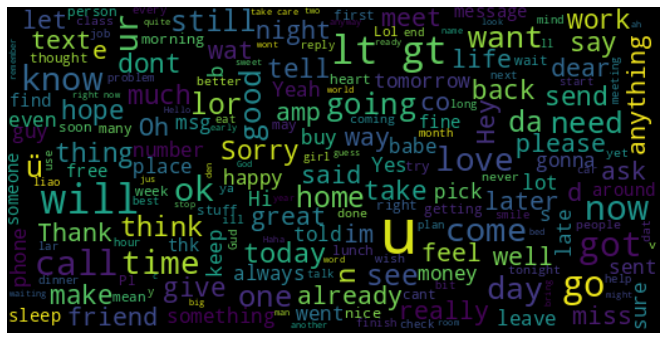

In [9]:
# extract the most common ham messages
hamText = ""
for text in pdf['Text'][pdf['Label'] == 'ham']:
    hamText += text

# wordcloud of ham messages
hamcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50).generate(hamText)
plt.figure(figsize=(12, 6))
plt.imshow(hamcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The ham message WordCloud above shows that words such as **now**, **work**, **How**, **Ok**, **Sorry** are the most commonly appeared words in ham messages.

The bar chart below shows that the labels are imbalanced.

Text(0.5, 1.0, 'Distribution of ham and spam sms messages')

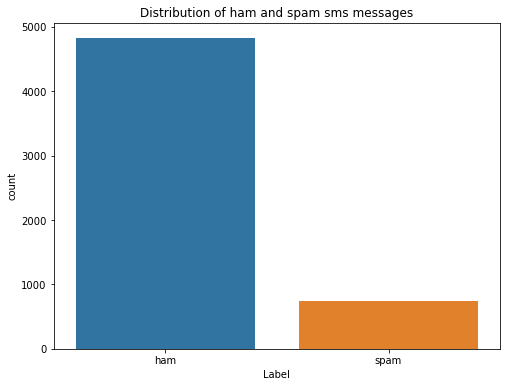

In [10]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(x=pdf.Label)
plt.title('Distribution of ham and spam sms messages')

In [11]:
pdf_per = pdf.groupby(['Label'],as_index=False).count().rename(columns={'Text':'Count'})

In [12]:
pdf_per['Percentage']= pdf_per['Count'].apply(lambda x: round(x/(pdf_per.Count[0]+pdf_per.Count[1])*100,2)).apply( lambda x : str(x) + '%')
pdf_per

,Label,Count,Percentage
0,ham,4825,86.59%
1,spam,747,13.41%


The above table further demonstrates that there are most frequent ham messages (86.59%) than spam (13.41%).

There exist several ways to handle the imbalance data, for example

- Use of appropriate evaluation metrics
- Resampling the training set : oversampling/upsampling or undersampling/downsampling
- Ensemble different resample datasets

In our problem, we use undersampling method, which is the process where we randomly delete some of the observations from the majority label so that the numbers in majority and minority labels are matched. As one can see below, now there are 747 messages of each label type.

In [13]:
# one way to fix it is to downsample the ham msg
ham_pdf = pdf[pdf.Label=='ham'].sample(n = len(pdf[pdf.Label=='spam']), random_state = 44)
spam_pdf = pdf[pdf.Label=='spam']

In [14]:
print('The shapes of ham and spam dataframes are {}, {}, respectively.'.format(ham_pdf.shape,spam_pdf.shape))

The shapes of ham and spam dataframes are (747, 2), (747, 2), respectively.


Now, let's create a new dataframe with the downsampled ham messages and the previos spam messages.

In [15]:
# Create a dataframe with the new ham and spam messages
new_pdf = pd.concat([ham_pdf,spam_pdf]).reset_index(drop=True)

Text(0.5, 0, 'Message types')

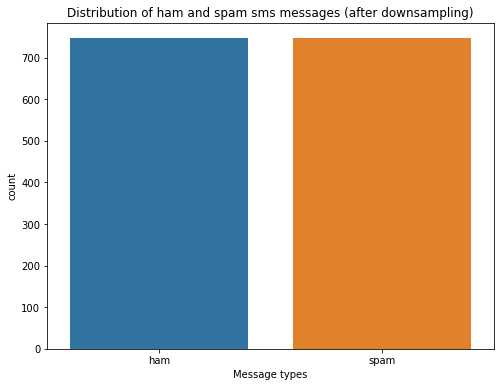

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(x=new_pdf.Label)
plt.title('Distribution of ham and spam sms messages (after downsampling)')
plt.xlabel('Message types')

### 2.3. Feature Creation 

In this section, we would like to extract as much as value out of the given data as we can to make accurate predictions later. Let's assume that spam messages tend to be longer than ham text messages. So, we'll create this feature and then we'll explore whether our assumption is accurate.

In the following cell, we calculate the length of each message and add a new column as **Body_len** to collect this information for each row.

In [17]:
#Add new feature
new_pdf['Body_len'] = new_pdf['Text'].apply(lambda x: len(x) - x.count(" "))
new_pdf.head()

,Label,Text,Body_len
0,ham,Height of recycling: Read twice- People spend ...,126
1,ham,Yup song bro. No creative. Neva test quality. ...,62
2,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to...",126
3,ham,Don't forget who owns you and who's private pr...,91
4,ham,Lol no. I just need to cash in my nitros. Hurr...,59


Now, we evaluate our newly created feature, that is **Body_len** to see if it might be providing any new value to the model for distinguishing spam from ham. So basically, we are going to build two histograms so as to look at the distribution of our body length for spam and ham messages.

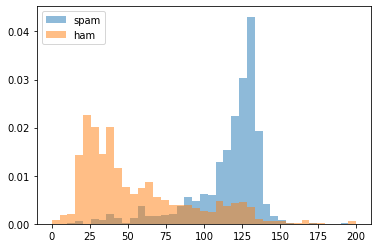

In [18]:
bins = np.linspace(0, 200, 40)
plt.hist(new_pdf[new_pdf['Label']=='spam']['Body_len'], bins, alpha=0.5, density=True, stacked=True, label='spam')
plt.hist(new_pdf[new_pdf['Label']=='ham']['Body_len'], bins, alpha=0.5, density=True, stacked=True, label='ham')
plt.legend(loc='upper left')
plt.show()

From the above plot, one can see that body length is very different for ham versus spam. So spam text messages seem to be quite a bit longer than ham text messages. So we can conclude that this extra feature can be really helpful for the model to distinguish ham from spam. 

### Store Data in IBM Cloud Object Store (COS)

Now, we would like to load this data into the IBM Could Object Store (COS).

Let's set the credentials and connect to the IBM Data store for persisting our data.

In [19]:
import ibmos2spark, os

credentials = {
    'endpoint': '********',
    'service_id': '********',
    'iam_service_endpoint': '********',
    'api_key': '********'
}

configuration_name = '********'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sdf = spark.createDataFrame(new_pdf)
sdf = sdf.repartition(1)
sdf.write.parquet(cos.url('SMSSpamData.parquet', 'advanceddatasciencecapstoneibm-donotdelete-pr-prnii9jvlql3tf'))

Now that the data has been stored in the IBM Cloud Object store, let us check and confirm that the stored data is looking good.

In [20]:
sdf_stored = spark.read.parquet(cos.url('SMSSpamData.parquet', 'advanceddatasciencecapstoneibm-donotdelete-pr-prnii9jvlql3tf'))
sdf_stored.show(20, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|Label|Text                                                                                                                                                                 |Body_len|
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|ham  |Height of recycling: Read twice- People spend time for earning money and the same money is spent for spending time!;-) Good morning.. keep smiling:-)                |126     |
|ham  |Yup song bro. No creative. Neva test quality. He said check review online.                                                                                           |62      |
|ham  |Feb  &lt;#&gt;  is "I LOVE U" day. Send dis to all ur "VALUED FRNDS" evn me. I